In [2]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.utils.data as data_utils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
from tqdm import tqdm
import timeit

C:\Users\matth\anaconda3\envs\earthquake-prediction\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Input data:  
- CCLE_expression.csv  
Gene expression TPM (transcript per million) values of the protein coding genes for DepMap cell lines  
log2(TPM+1) goes from 0.00 to 17.78


- CRISPR_gene_effect.csv
Gene effect of the protein coding genes for DepMap cell lines
Gene Effect scores derived from CRISPR knockout screens published by Broad’s Achilles and Sanger’s SCORE projects.  
Negative scores imply cell growth inhibition and/or death following gene knockout. Scores are normalized such that nonessential genes have a median score of 0 and independently identified common essentials have a median score of -1.  
SCORE goes from -3.89 to 2.73.



Genes:17386  
Cell Lines:1086  
Primary Diseases:31  
Lineages:28  

## Extract data 

In [3]:
# Extract gene expression from CCLE_expression.csv
df = pd.read_csv('data/CCLE_expression.csv')
gene_expression = df.rename(columns={"Unnamed: 0":"DepMap"}).set_index("DepMap").dropna()

# Extract gene effect from CRISPR_gene_effect.csv
df = pd.read_csv('data/CRISPR_gene_effect.csv')
gene_effect = df.rename(columns={"DepMap_ID":"DepMap"}).set_index("DepMap").dropna()

## Clean datasets

In [4]:
gene_expression = gene_expression.sort_values(by = 'DepMap').reindex(sorted(gene_expression.columns), axis = 1)
gene_effect = gene_effect.sort_values(by = 'DepMap').reindex(sorted(gene_effect.columns), axis = 1)

In [5]:
def intersection(lst1, lst2):
    return list(set(lst1).intersection(lst2))

In [6]:
# Keep genes in common
cols1 = gene_expression.columns
cols2 = gene_effect.columns

cols = sorted(intersection(cols1, cols2))
gene_expression = gene_expression[cols]
gene_effect = gene_effect[cols]

In [7]:
# Keep cell lines in common
rows1 = list(gene_expression.index)
rows2 = list(gene_effect.index)

rows = intersection(rows1, rows2)
gene_expression = gene_expression.reindex(index = sorted(rows))
gene_effect = gene_effect.reindex(index = sorted(rows))

In [8]:
len(cols)

17283

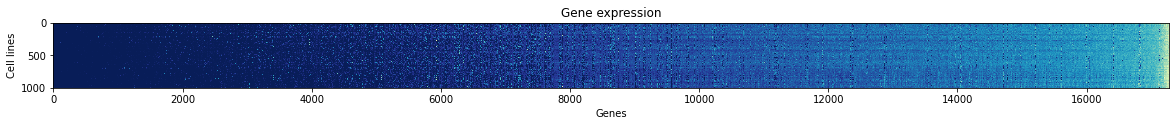

In [9]:
sorted_df = gene_expression.reindex(gene_expression.mean().sort_values().index, axis=1)
#sorted_df['Mean'] = df.mean(axis=0)
#sorted_df = sorted_df.sort_values(by='Mean', axis=0)
fig = plt.figure(figsize=(20,20))
plt.imshow(-sorted_df.to_numpy(), cmap="YlGnBu",interpolation='nearest')
plt.xlabel("Genes")
plt.ylabel("Cell lines")
plt.title("Gene expression")
plt.show()

In [10]:
gepxrflat = gene_expression.reindex(gene_expression.mean().sort_values().index, axis=1).to_numpy().flatten()
geffflat = gene_effect.reindex(gene_expression.mean().sort_values().index, axis=1).to_numpy().flatten()

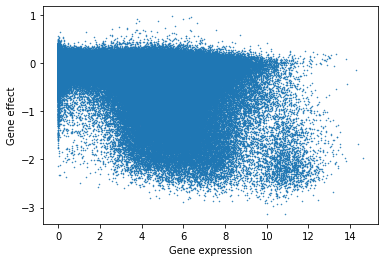

In [11]:
nb_pts = 500000
plt.scatter(gepxrflat[:nb_pts], geffflat[:nb_pts], marker='.', s=1)
plt.xlabel("Gene expression")
plt.ylabel("Gene effect")
plt.show()

# ML

## Define X,y

In [12]:
#loss = F.binary_cross_entropy_with_logits # numerically stable
loss_function = F.mse_loss

device="cuda"

In [13]:
nb_genes = 5_000
nb_cell_lines = 500

In [14]:
X = gene_expression.iloc[:nb_cell_lines,:nb_genes].to_numpy('float')
y = gene_effect.iloc[:nb_cell_lines,:nb_genes].to_numpy('float')

In [15]:
def set_split(X, y, proportion):
    index = np.arange(len(X))
    np.random.shuffle(index)
    sum_p = sum(proportion)
    proportion = [p / sum_p for p in proportion]
    prop=0
    N = len(index)
    X_splits = []
    y_splits = []
    for i in range(len(proportion)):
        start_index = round( N*prop )
        end_index = round( N*(prop+proportion[i]) )
        
        set_index = index[start_index: end_index]
        X_splits.append( X[set_index] )
        y_splits.append( y[set_index] )
        
        prop += proportion[i]

    return X_splits, y_splits

In [16]:
X_splits, y_splits = set_split(X, y, [0.7,0.2,0.1])
X_splits = [torch.tensor(x, device=device) for x in X_splits]
y_splits = [torch.tensor(y_, device=device) for y_ in y_splits]

X_train, X_val, X_test = X_splits
y_train, y_val, y_test = y_splits

In [17]:
print(X_train.size(), X_val.size(), X_test.size())

torch.Size([350, 5000]) torch.Size([100, 5000]) torch.Size([50, 5000])


In [18]:
def k_fold_split(X, y, K, prop_train_test, device):
    X_splits, y_splits = set_split(X, y, prop_train_test)
    X_train, X_test = X_splits
    y_train, y_test = y_splits
    X_folds, y_folds = set_split(X_train, y_train, [1/K] * K)
    
    X_folds = [torch.tensor(x, device=device) for x in X_folds]
    y_folds = [torch.tensor(y_, device=device) for y_ in y_folds]
    X_test = torch.tensor(X_test, device=device)
    y_test = torch.tensor(y_test, device=device)

    return X_folds, y_folds, X_test, y_test

# X_folds, y_folds, X_test, y_test = k_fold_split(X, y, 5, [0.9, 0.1], device)

## Define model

In [19]:
class Net(torch.nn.Module):
    def __init__(self, input_size, output_size=None):
        super(Net, self).__init__()
        if output_size is None:
            output_size = input_size
        
        self.layer = torch.nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.layer(x.float())   
        return x

In [20]:
model = Net(nb_genes).to(device)

## Train model

In [21]:
def run_one_epoch(train_flag, dataloader, model, optimizer, loss_function, device):

    torch.set_grad_enabled(train_flag)
    model.train() if train_flag else model.eval() 

    losses = []
    accuracies = []

    for (x,y) in dataloader:

        (x, y) = ( x.to(device), y.to(device) ) # transfer data to device

        output = model(x) # forward pass
        output = output.squeeze() # remove spurious channel dimension
        loss = loss_function( output.float(), y.float() )

        if train_flag:  # back propagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        losses.append(loss.detach().cpu().numpy())
        
    return np.mean(losses)

In [22]:
# TODO make wrapper function. 

def train_model(model, X_train, y_train, X_val, y_val, 
                optimizer, loss_function, device, 
                batch_size=5, epochs=20, patience=10, 
                verbose=True):
    """
    Train a model and record loss.
    """

    # Make new Dataset and DataLoader objects for both training and validation data.
    train_dataset = data_utils.TensorDataset(X_train, y_train)
    train_dataloader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = data_utils.TensorDataset(X_val, y_val)
    val_dataloader = data_utils.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    # Run the training loop with early stopping. 
    train_losses = []
    val_losses = []
    patience_counter = patience
    best_val_loss = np.inf
    check_point_filename = 'model_checkpoint.pt' # to save the best model fit to date
    for epoch in tqdm(range(epochs)):
        start_time = timeit.default_timer()
        train_loss = run_one_epoch(True, train_dataloader, model, optimizer, loss_function, device)
        val_loss = run_one_epoch(False, val_dataloader, model, optimizer, loss_function, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if val_loss < best_val_loss: 
            torch.save(model.state_dict(), check_point_filename)
            best_val_loss = val_loss
            patience_counter = patience
        else: 
            patience_counter -= 1
            if patience_counter <= 0: 
                model.load_state_dict(torch.load(check_point_filename)) # recover the best model so far
                break
        elapsed = float(timeit.default_timer() - start_time)
        if verbose:
            print("Epoch %i | took %.2fs | Train loss: %.4f | Val loss: %.4f | Patience left: %i" % 
              (epoch+1, elapsed, train_loss, val_loss, patience_counter ))

    # Return the fitted model (not strictly necessary since this happens "in place"), train and validation accuracies.
    return model, train_losses, val_losses


In [23]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

In [24]:
trained_model, train_losses, val_losses = train_model(model, X_train, y_train, X_val, y_val, 
                                                      optimizer, loss_function, device,
                                                      epochs=40, verbose=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:28<00:00,  2.22s/it]


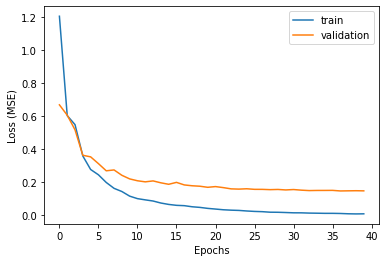

In [25]:
plt.plot(train_losses, label = "train")
plt.plot(val_losses, label = "validation")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.show()

## GraphNN

In [31]:
import torch
from torch import Tensor
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='.', name='Cora')

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        # x: Node feature matrix of shape [num_nodes, in_channels]
        # edge_index: Graph connectivity matrix of shape [2, num_edges]
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

model = GCN(dataset.num_features, 16, dataset.num_classes)

In [34]:
import torch.nn.functional as F
import gc

data = dataset[0]
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

losses = []
#del loss
gc.collect()

for epoch in range(200):
    pred = model(data.x, data.edge_index)
    loss = F.cross_entropy(pred[data.train_mask], data.y[data.train_mask])
    losses.append(loss.item())
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
import torch
from torch import Tensor
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing

class EdgeConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr="max")  # "Max" aggregation.
        self.mlp = Sequential(
            Linear(2 * in_channels, out_channels),
            ReLU(),
            Linear(out_channels, out_channels),
        )

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        # x: Node feature matrix of shape [num_nodes, in_channels]
        # edge_index: Graph connectivity matrix of shape [2, num_edges]
        return self.propagate(edge_index, x=x)  # shape [num_nodes, out_channels]

    def message(self, x_j: Tensor, x_i: Tensor) -> Tensor:
        # x_j: Source node features of shape [num_edges, in_channels]
        # x_i: Target node features of shape [num_edges, in_channels]
        edge_features = torch.cat([x_i, x_j - x_i], dim=-1)
        return self.mlp(edge_features)  # shape [num_edges, out_channels]

In [28]:
#!pip install torch-quiver>=0.1.1

## Retrieving PPI Data

<font color = "blue" size = 4> **IMPORTANT: The string format is 'GeneName (GeneID)' for column names, e.g. 'A1BG (1)'.**

We have gene names and gene IDs in our datasets, and we'd like to find associated protein IDs in order to retrieve data from STRING database or any PPI database. I first retrieved gene ID from gene name but turned out we already have that information in the dataset. 

Nevertheless, here's how to convert gene names into gene IDs in case you don't:
https://nbviewer.org/gist/newgene/6771106

In [1]:
#!pip install mygene

In [2]:
import mygene
mg = mygene.MyGeneInfo()

In [3]:
names = ['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2', 'A4GALT', 'A4GNT', 'AAAS']

In [4]:
out = mg.querymany(names, scopes='symbol', fields='ensembl.gene', species='human')

querying 1-8...done.
Finished.


In [5]:
ids = [out[i]["_id"] if '_id' in out[i].keys() else None for i in range(len(out))]
print(ids)

['1', '29974', '2', '144568', '127550', '53947', '51146', '8086']


In [6]:
g = mg.getgene(ids[0])
print(type(g))
print(g.keys())

<class 'dict'>
dict_keys(['AllianceGenome', 'HGNC', 'MIM', '_id', '_version', 'accession', 'alias', 'ensembl', 'entrezgene', 'exac', 'exons', 'exons_hg19', 'generif', 'genomic_pos', 'genomic_pos_hg19', 'go', 'homologene', 'interpro', 'ipi', 'map_location', 'name', 'other_names', 'pantherdb', 'pathway', 'pfam', 'pharmgkb', 'pharos', 'prosite', 'reagent', 'refseq', 'reporter', 'retired', 'summary', 'symbol', 'taxid', 'type_of_gene', 'umls', 'unigene', 'uniprot', 'wikipedia'])


In [7]:
#!pip install biopython

In [31]:
from Bio import Entrez
#Entrez.email = "Your.Name.Here@example.org"
#handle = Entrez.efetch(db="nucleotide", id="AY851612", rettype="gb", retmode="text")
handle = Entrez.elink(db="protein", dbfrom="gene", id=("93100", "223646"), by_id=True)
#print(handle.readline().strip())
record = Entrez.read(handle)
handle.close()

In [33]:
"""
from Bio import Entrez
Entrez.email = "Your.Name.Here@example.org"
handle = Entrez.esearch(db="nucleotide", retmax=10, term="opuntia[ORGN] accD", idtype="acc")
record = Entrez.read(handle)
handle.close()
print(record["IdList"])
"""

'\nfrom Bio import Entrez\nEntrez.email = "Your.Name.Here@example.org"\nhandle = Entrez.esearch(db="nucleotide", retmax=10, term="opuntia[ORGN] accD", idtype="acc")\nrecord = Entrez.read(handle)\nhandle.close()\nprint(record["IdList"])\n'

In [34]:
record[0]

{'ERROR': [], 'LinkSetDbHistory': [], 'LinkSetDb': [{'Link': [{'Id': '2217373768'}, {'Id': '1387845369'}, {'Id': '1387845338'}, {'Id': '1370513171'}, {'Id': '1370513169'}, {'Id': '1034662000'}, {'Id': '1034661998'}, {'Id': '1034661996'}, {'Id': '1034661994'}, {'Id': '1034661992'}, {'Id': '558472750'}, {'Id': '545685826'}, {'Id': '194394158'}, {'Id': '166221824'}, {'Id': '154936864'}, {'Id': '122346659'}, {'Id': '119602646'}, {'Id': '119602645'}, {'Id': '119602644'}, {'Id': '119602643'}, {'Id': '119602642'}, {'Id': '37787309'}, {'Id': '37787307'}, {'Id': '37787305'}, {'Id': '33991172'}, {'Id': '21619615'}, {'Id': '10834676'}], 'DbTo': 'protein', 'LinkName': 'gene_protein'}, {'Link': [{'Id': '2217373768'}, {'Id': '1387845369'}, {'Id': '1387845338'}, {'Id': '1370513171'}, {'Id': '1370513169'}, {'Id': '1034662000'}, {'Id': '1034661998'}, {'Id': '1034661996'}, {'Id': '1034661994'}, {'Id': '1034661992'}, {'Id': '558472750'}, {'Id': '194394158'}], 'DbTo': 'protein', 'LinkName': 'gene_protein_

In [35]:
import sys

from Bio import Entrez

# *Always* tell NCBI who you are
Entrez.email = "your email here"


def retrieve_annotation(id_list):

    """Annotates Entrez Gene IDs using Bio.Entrez, in particular epost (to
    submit the data to NCBI) and esummary to retrieve the information.
    Returns a list of dictionaries with the annotations."""

    request = Entrez.epost("gene", id=",".join(id_list))
    try:
        result = Entrez.read(request)
    except RuntimeError as e:
        # FIXME: How generate NAs instead of causing an error with invalid IDs?
        print("An error occurred while retrieving the annotations.")
        print("The error returned was %s" % e)
        sys.exit(-1)

    webEnv = result["WebEnv"]
    queryKey = result["QueryKey"]
    data = Entrez.esummary(db="gene", webenv=webEnv, query_key=queryKey)
    annotations = Entrez.read(data)

    print("Retrieved %d annotations for %d genes" % (len(annotations), len(id_list)) )

    return annotations

In [36]:
def print_data(annotation):
    for gene_data in annotation:
        print("data keys: ")
        #print(gene_data.keys())
        gene_id = gene_data["Id"]
        gene_symbol = gene_data["NomenclatureSymbol"]
        gene_name = gene_data["Description"]
        print("ID: %s - Gene Symbol: %s - Gene Name: %s" % (
            gene_id,
            gene_symbol,
            gene_name)
             )

In [37]:
id_list = ids
annotations = retrieve_annotation(id_list)
print(type(annotations))
#print_data(annotations)


Retrieved 1 annotations for 8 genes
<class 'Bio.Entrez.Parser.DictionaryElement'>
